In [1]:
%load_ext autoreload
%matplotlib inline

In [2]:
%autoreload 2

from IPython import display

from utils import Logger

import torch
from torch import nn, optim
from torch.autograd.variable import Variable
from torchvision import transforms, datasets

In [3]:
DATA_FOLDER = './torch_data/VGAN/MNIST'

In [4]:
def mnist_data():
    compose = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((.5, .5, .5), (.5, .5, .5))
        ])
    out_dir = '{}/dataset'.format(DATA_FOLDER)
    return datasets.MNIST(root=out_dir, train=True, transform=compose, download=True)

In [5]:
# Load data# Load  
data = mnist_data()
# Create loader with data, so that we can iterate over it
data_loader = torch.utils.data.DataLoader(data, batch_size=100, shuffle=True)
# Num batches
num_batches = len(data_loader)

In [6]:
class DiscriminatorNet(torch.nn.Module):
    '''
    A three hidden-layer discriminative neural network
    '''
    def __init__(self):
        super(DiscriminatorNet, self).__init__()
        n_features = 784
        n_out = 1
        
        self.hidden0 = nn.Sequential( 
            nn.Linear(n_features, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.hidden1 = nn.Sequential(
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.out = nn.Sequential(
            torch.nn.Linear(256, n_out),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x

In [7]:
class GeneratorNet(torch.nn.Module):
    '''
    A three hidden-layer generative neural network
    '''
    def __init__(self):
        super(GeneratorNet, self).__init__()
        n_features = 100
        n_out = 784
        
        self.hidden0 = nn.Sequential(
            nn.Linear(n_features, 256),
            nn.LeakyReLU(0.2)
        )
        self.hidden1 = nn.Sequential(            
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2)
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2)
        )
        
        self.out = nn.Sequential(
            nn.Linear(1024, n_out),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x

In [8]:
# Resize image to 784 dimensional vector
def images_to_vectors(images):
    return images.view(images.size(0), 784)

# Resize vector to 28x28 image
def vectors_to_images(vectors):
    return vectors.view(vectors.size(0), 1, 28, 28)

# Noise for Generator
def noise(size):
    n = Variable(torch.randn(size, 100))
    if torch.cuda.is_available(): return n.cuda() 
    return n

In [9]:
# Defining ground-truth for real and fake images

def real_data_groundtruth(size):
    '''
    Tensor containing ones, with shape = size
    '''
    data = Variable(torch.ones(size, 1))
    if torch.cuda.is_available(): 
        return data.cuda()
    return data

def fake_data_groundtruth(size):
    '''
    Tensor containing zeros, with shape = size
    '''
    data = Variable(torch.zeros(size, 1))
    if torch.cuda.is_available(): 
        return data.cuda()
    return data

In [10]:
def train_discriminator(optimizer, real_data, fake_data):
    optimizer.zero_grad()
    
    # Real Data
    prediction_real = discriminator(real_data)
    error_real = loss(prediction_real, real_data_groundtruth(real_data.size(0)))
    error_real.backward()

    # Fake Data
    prediction_fake = discriminator(fake_data)
    error_fake = loss(prediction_fake, fake_data_groundtruth(fake_data.size(0)))
    error_fake.backward()
    
    # Update weights with gradients
    optimizer.step()
    
    total_error = error_real + error_fake
    
    # Return error
    return total_error, prediction_real, prediction_fake

In [11]:
def train_generator(optimizer, fake_data):
    optimizer.zero_grad()
    
    # Fake Data
    prediction = discriminator(fake_data)
    error = loss(prediction, real_data_groundtruth(fake_data.size(0)))
    error.backward()
    
    # Update weights with gradients
    optimizer.step()
    
    # Return error
    return error

In [12]:
# Test Samples
num_test_samples = 16
test_noise = noise(num_test_samples)

In [13]:
# Initialize networks
discriminator = DiscriminatorNet()
generator = GeneratorNet()
if torch.cuda.is_available():
    discriminator.cuda()
    generator.cuda()

In [14]:
# Optimizers
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002)
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002)

# Loss function
loss = nn.BCELoss()

# Number of steps to apply to the discriminator
d_steps = 1  # In Goodfellow et. al 2014 this variable is assigned to 1 ??????
# Number of epochs
num_epochs = 200

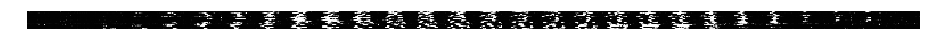

Epoch: [98/200], Batch Num: [0/600]
Discriminator Loss: 1.1868, Generator Loss: 1.0194
D(x): 0.5680, D(G(z)): 0.3824


In [ ]:
'''
Start Training
'''
logger = Logger(model_name='VGAN', data_name='MNIST')

for epoch in range(num_epochs):
    for i, (image, label) in enumerate(data_loader):
        
        ###############################################
        #              Train Discriminator            #
        ###############################################    
        real_data = Variable(images_to_vectors(image))
        if torch.cuda.is_available(): 
            real_data = real_data.cuda()
        # Fake Data
        fake_data = generator(noise(real_data.size(0))).detach()
        d_error, d_pred_real, d_pred_fake = train_discriminator(d_optimizer, real_data, fake_data)
        
        ###############################################
        #              Train Generator                #
        ###############################################
        fake_data = generator(noise(image.size(0)))
        g_error = train_generator(g_optimizer, fake_data)
        
        # Log error
        logger.log(d_error, g_error, epoch, i, num_batches)
        
        # Display Progress
        if (i) % 100 == 0:
            display.clear_output(True)
            # Display Images
            test_images = generator(test_noise).data.cpu()
            logger.log_images(test_images, num_test_samples, epoch, i, num_batches);
            # Display status Logs
            logger.display_status(
                epoch, num_epochs, i, num_batches,
                d_error, g_error, d_pred_real, d_pred_fake
            )
        # Model Checkpoints
        logger.save_models(generator, discriminator, epoch)